## Chargement du dataset

In [48]:
import numpy as np
import os

# Imports nécessaires pour construire un modèle LeNet 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import Rescaling

# Pour importer le datasets
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Pour la compilation du modèle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Pour visualiser les performances
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

print(tf.__version__)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# Chargement du dataset
#dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample"
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample_balanced"
img_size = (224, 224)  # Taille cible
batch_size = 32
class_names = sorted(os.listdir(dir_name))
nb_class = len(class_names)

train_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

# Ajout d'optimisation : mise en cache et préchargement
#train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()

2.19.0
Num GPUs Available:  1
Found 54000 files belonging to 27 classes.
Using 43200 files for training.
Found 54000 files belonging to 27 classes.
Using 10800 files for validation.


## Structure du modèle

In [51]:
import tensorflow as tf

# couche personnalisée pour gérer le pré-traitement des images 
class VGGPreprocess(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.keras.applications.vgg16.preprocess_input(inputs)

# Modèle de base
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Entrée du modèle
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pipeline complet
x = tf.keras.layers.RandomFlip("horizontal")(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)
x = tf.keras.layers.RandomContrast(0.2)(x)

x = VGGPreprocess()(x)
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(nb_class, activation='softmax')(x)

# Construction finale
model = tf.keras.Model(inputs, outputs)

model.summary()

## Entrainement du modèle

Phase 1: Entraînement avec modèle de base gelé
Epoch 1/30
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.0646 - loss: 4.1643  
Epoch 1: val_accuracy improved from -inf to 0.26935, saving model to ../../src/models/vgg16_best_model.keras
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 207s 151ms/step - accuracy: 0.0647 - loss: 4.1641 - val_accuracy: 0.2694 - val_loss: 3.1500 - learning_rate: 1.0000e-04
Epoch 2/30
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1590 - loss: 3.4711  
Epoch 2: val_accuracy improved from 0.26935 to 0.32259, saving model to ../../src/models/vgg16_best_model.keras
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 204s 151ms/step - accuracy: 0.1590 - loss: 3.4710 - val_accuracy: 0.3226 - val_loss: 2.8591 - learning_rate: 1.0000e-04
Epoch 3/30
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2111 - loss: 3.2034  
Epoch 3: val_accuracy improved from 0.32259 to 0.34713, saving model to ../../src/models/vgg16_best_model.keras
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 200s 148ms/

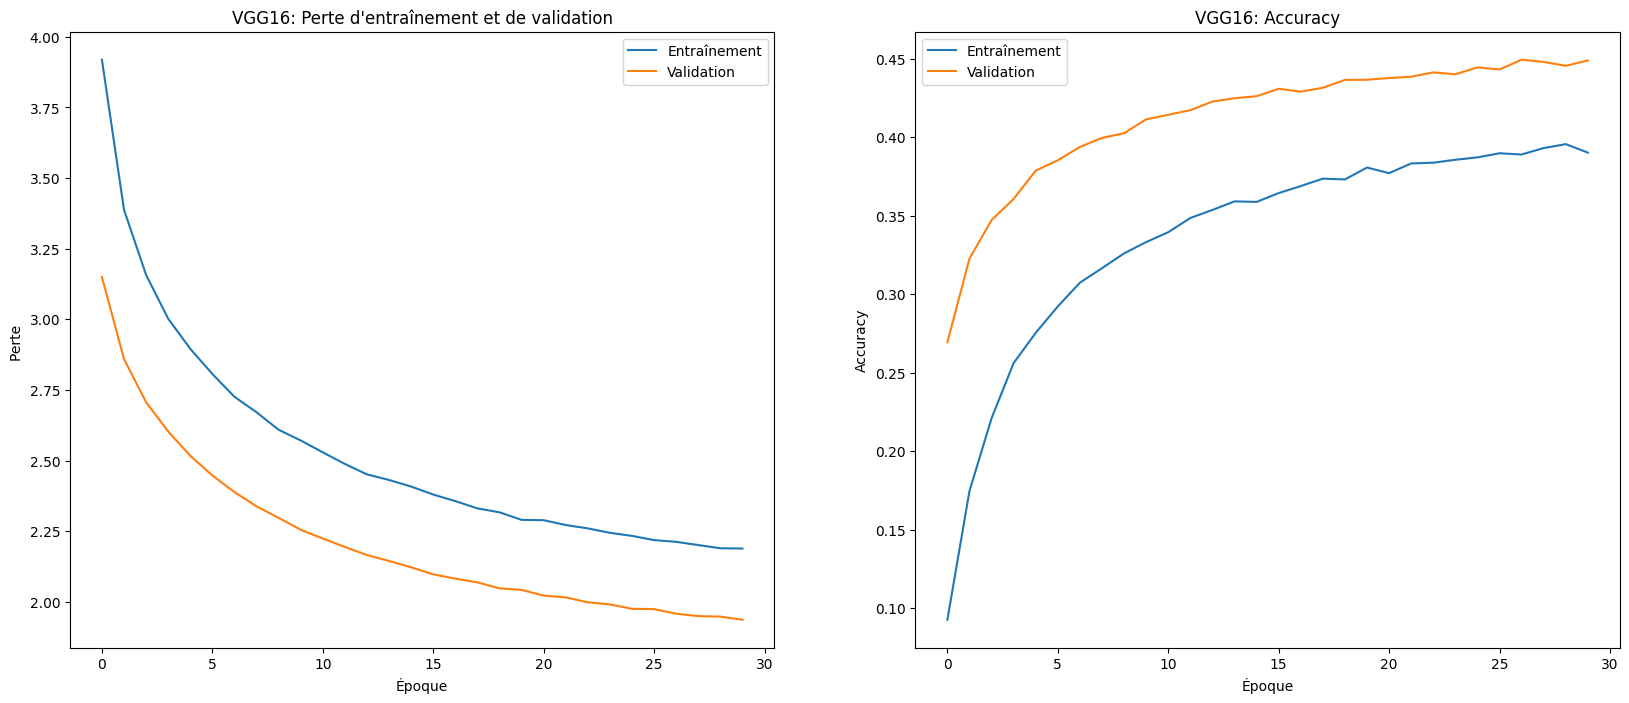

Analyse entrainement VGG16 (fine tunning)


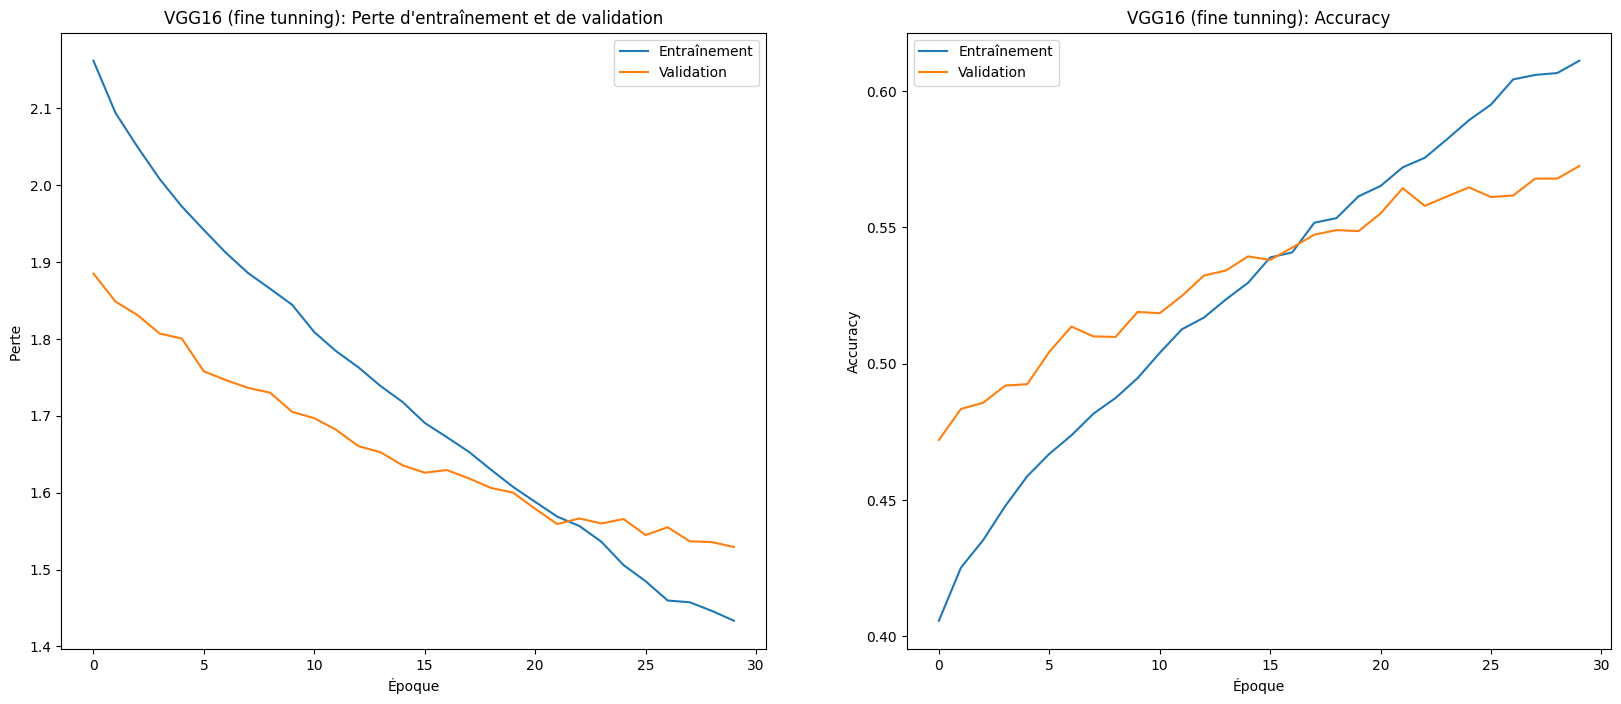

338/338 ━━━━━━━━━━━━━━━━━━━━ 37s 110ms/step - accuracy: 0.5760 - loss: 1.5367
Précision de validation finale: 0.5725


In [52]:
# Définition des callbacks
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '../../src/models/vgg16_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)

# Étape 2: Entraîner avec le modèle de base gelé
print("Phase 1: Entraînement avec modèle de base gelé")

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),                 
    metrics=['accuracy'])  


model_history = model.fit(train_ds,           
                           validation_data=val_ds,
                           epochs=30,
                           callbacks=[lr_reducer, early_stopping, checkpoint])  

# Étape 3: Fine-tuning - dégeler partiellement le modèle de base
print("Phase 2: Fine-tuning")

# Dégeler le 5ème bloc de convolution
for layer in base_model.layers:
    if "block5_" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Vérification des couches dégelées
trainable_layers = [layer.name for layer in base_model.layers if layer.trainable]
print(f"Couches dégelées pour le fine-tuning: {trainable_layers}")

# Recompiler avec un taux d'apprentissage plus faible
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
    metrics=['accuracy']
)

# Entraîner avec fine-tuning
history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[lr_reducer, early_stopping, checkpoint]
)

# Analyse de l'entainement
print("Analyse entrainement VGG16 (modèle de base)")
display_results(model_history, "VGG16")

# Analyse de l'entainement
print("Analyse entrainement VGG16 (fine tunning)")
display_results(history_phase2, "VGG16 (fine tunning)")

# Évaluation finale
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")

# Sauvegarde du modèle final
model.save('../../src/models/vgg16_final_model.keras')

## Analyse de la performance par classe

In [57]:
# Chargement du model
model_loaded = tf.keras.models.load_model('../../src/models/vgg16_final_model.keras', safe_mode=False)

# Check
model_loaded.summary()


NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_121>',)
  • kwargs={'mask': 'None'}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-18 16:46:47.523694: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


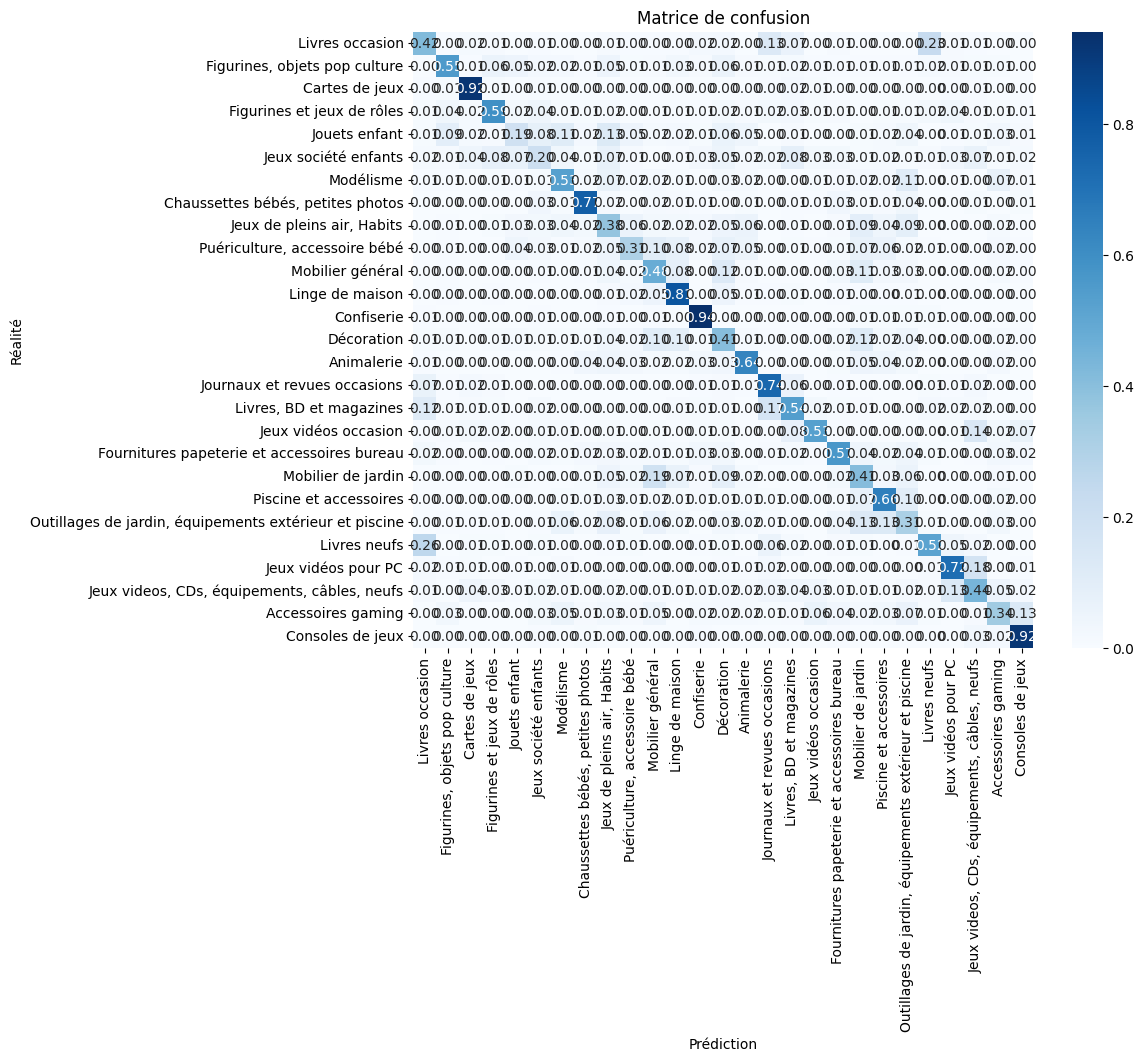

                                                        precision    recall  f1-score   support

                                    Accessoires gaming       0.45      0.34      0.39       398
                                            Animalerie       0.65      0.64      0.65       420
                                        Cartes de jeux       0.81      0.92      0.86       413
                     Chaussettes bébés, petites photos       0.76      0.77      0.77       390
                                            Confiserie       0.76      0.94      0.84       391
                                      Consoles de jeux       0.74      0.92      0.82       407
                                            Décoration       0.33      0.41      0.37       407
                            Figurines et jeux de rôles       0.65      0.59      0.62       380
                         Figurines, objets pop culture       0.67      0.55      0.61       397
           Fournitures papeterie et acc

In [42]:
### ANALYSE DE LA PERFORMACE ###
import seaborn as sns

# 1. Générer des prédictions sur l'ensemble de validation
# Prévoir les classes pour tous les échantillons de validation
predictions = []
labels = []

# Récupérer toutes les étiquettes et prédictions
for images, true_labels in val_ds:
    pred = model.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    
    predictions.extend(pred_classes)
    labels.extend(true_labels.numpy())

# Convertir en arrays numpy
predictions = np.array(predictions)
labels = np.array(labels)

# dictionnaire des catégories
categories = {
    10: "Livres occasion",
    2280: "Journaux et revues occasions",
    2403: "Livres, BD et magazines",
    2522: "Fournitures papeterie et accessoires bureau",
    2705: "Livres neufs",
    40: "Jeux videos, CDs, équipements, câbles, neufs",
    50: "Accessoires gaming",
    60: "Consoles de jeux",
    2462: "Jeux vidéos occasion",
    2905: "Jeux vidéos pour PC",
    1140: "Figurines, objets pop culture",
    1160: "Cartes de jeux",
    1180: "Figurines et jeux de rôles",
    1280: "Jouets enfant",
    1281: "Jeux société enfants",
    1300: "Modélisme",
    1302: "Jeux de pleins air, Habits",
    1560: "Mobilier général",
    2582: "Mobilier de jardin",
    1320: "Puériculture, accessoire bébé",
    2220: "Animalerie",
    2583: "Piscine et accessoires",
    2585: "Outillages de jardin, équipements extérieur et piscine",
    1920: "Linge de maison",
    2060: "Décoration",
    1301: "Chaussettes bébés, petites photos",
    1940: "Confiserie"
}

class_indices = val_ds.class_names # correspondance index vers idcategory
predicted_ids = [class_indices[i] for i in predictions]
true_ids = [class_indices[i] for i in labels]

predicted_cat = [categories.get(int(cid)) for cid in predicted_ids]
true_cat = [categories.get(int(cid)) for cid in true_ids]

real_class_names = [categories.get(int(cid)) for cid in class_indices]

# 2. Créer et afficher la matrice de confusion
cm = confusion_matrix(labels, predictions, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=real_class_names, yticklabels=real_class_names)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()

print(classification_report(true_cat, predicted_cat))

In [41]:
# Ton dictionnaire
categories = {
    10: "Livres occasion",
    2280: "Journaux et revues occasions",
    2403: "Livres, BD et magazines",
    2522: "Fournitures papeterie et accessoires bureau",
    2705: "Livres neufs",
    40: "Jeux videos, CDs, équipements, câbles, neufs",
    50: "Accessoires gaming",
    60: "Consoles de jeux",
    2462: "Jeux vidéos occasion",
    2905: "Jeux vidéos pour PC",
    1140: "Figurines, objets pop culture",
    1160: "Cartes de jeux",
    1180: "Figurines et jeux de rôles",
    1280: "Jouets enfant",
    1281: "Jeux société enfants",
    1300: "Modélisme",
    1302: "Jeux de pleins air, Habits",
    1560: "Mobilier général",
    2582: "Mobilier de jardin",
    1320: "Puériculture, accessoire bébé",
    2220: "Animalerie",
    2583: "Piscine et accessoires",
    2585: "Outillages de jardin, équipements extérieur et piscine",
    1920: "Linge de maison",
    2060: "Décoration",
    1301: "Chaussettes bébés, petites photos",
    1940: "Confiserie"
}

class_indices = val_ds.class_names
predicted_ids = [class_indices[i] for i in predictions]
true_ids = [class_indices[i] for i in labels]

real_class_names = [categories.get(int(cid)) for cid in class_indices]

real_class_names

['Livres occasion',
 'Figurines, objets pop culture',
 'Cartes de jeux',
 'Figurines et jeux de rôles',
 'Jouets enfant',
 'Jeux société enfants',
 'Modélisme',
 'Chaussettes bébés, petites photos',
 'Jeux de pleins air, Habits',
 'Puériculture, accessoire bébé',
 'Mobilier général',
 'Linge de maison',
 'Confiserie',
 'Décoration',
 'Animalerie',
 'Journaux et revues occasions',
 'Livres, BD et magazines',
 'Jeux vidéos occasion',
 'Fournitures papeterie et accessoires bureau',
 'Mobilier de jardin',
 'Piscine et accessoires',
 'Outillages de jardin, équipements extérieur et piscine',
 'Livres neufs',
 'Jeux vidéos pour PC',
 'Jeux videos, CDs, équipements, câbles, neufs',
 'Accessoires gaming',
 'Consoles de jeux']